In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

In [ ]:
generator = tf.keras.models.load_model('/content/drive/MyDrive/Generator')

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(generator)
tflite_model = converter.convert()


In [ ]:
import pathlib
tflite_models_dir = pathlib.Path("/content/Generator/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)


In [ ]:
tflite_model_file = tflite_models_dir/"generator.tflite"
tflite_model_file.write_bytes(tflite_model)


45535416

In [ ]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
tflite_model_quant_file = tflite_models_dir/"generator_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_quant_model)


11480232

In [ ]:
!ls -lh {tflite_models_dir}

total 55M
-rw-r--r-- 1 root root 11M Nov  8 04:10 generator_quant.tflite
-rw-r--r-- 1 root root 44M Nov  8 04:09 generator.tflite


In [ ]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [ ]:
interpreter_quant = tf.lite.Interpreter(model_path=str(tflite_model_quant_file))
interpreter_quant.allocate_tensors()


In [ ]:
import matplotlib.pyplot as plt

In [ ]:

def generate_images(interpreter, test_input, tar):
    # Assuming you already ran the inference with the TFLite interpreter
    prediction = interpreter.get_tensor(output_details[0]['index'])

    plt.figure(figsize=(15, 15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()


In [ ]:
PATH = '/content/drive/MyDrive/output/train/'
BLUR = PATH + 'blur'
SHARP = PATH + 'sharp'
TEST_PATH = '/content/drive/MyDrive/output/test/'
TEST_BLUR = TEST_PATH + 'blur'
TEST_SHARP = TEST_PATH + 'sharp'

In [ ]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3

In [ ]:

LAMBDA = 100

In [ ]:
def load(file_path):
  image_file = tf.strings.split(file_path, os.sep)[-1]
  image_b = tf.io.read_file(BLUR + '/' + image_file)
  image_b = tf.io.decode_png(image_b)
  image_s = tf.io.read_file(SHARP + '/' + image_file)
  image_s = tf.io.decode_png(image_s)

  input_image = tf.cast(image_b, tf.float32)
  sharp_image = tf.cast(image_s, tf.float32)

  return input_image, sharp_image

In [ ]:
def load_test(file_path):
  image_file = tf.strings.split(file_path, os.sep)[-1]
  image_b = tf.io.read_file(TEST_BLUR + '/' + image_file)
  image_b = tf.io.decode_png(image_b)
  image_s = tf.io.read_file(TEST_SHARP + '/' + image_file)
  image_s = tf.io.decode_png(image_s)

  input_image = tf.cast(image_b, tf.float32)
  sharp_image = tf.cast(image_s, tf.float32)

  return input_image, sharp_image

In [ ]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [ ]:
def random_crop(input_image, real_image):
	stacked_image = tf.stack([input_image, real_image], axis=0)
	cropped_image = tf.image.random_crop(
	stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

	return cropped_image[0], cropped_image[1]

In [ ]:
def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

In [ ]:
@tf.function()
def random_jitter(input_image, real_image):
	input_image, real_image = resize(input_image, real_image, 286, 286)
	input_image, real_image = random_crop(input_image, real_image)

	if tf.random.uniform(()) > 0.5:
		input_image = tf.image.flip_left_right(input_image)
		real_image = tf.image.flip_left_right(real_image)

	return input_image, real_image

In [ ]:
def load_image_test(image_file):
  input_image, real_image = load_test(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [ ]:
def load_image_train(image_file):
	input_image, real_image = load(image_file)
	input_image, real_image = random_jitter(input_image, real_image)
	input_image, real_image = normalize(input_image, real_image)
	return input_image, real_image

In [ ]:
import os

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(SHARP + '/*.png'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset = tf.data.Dataset.list_files(str(TEST_SHARP + '/*.png'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [ ]:
test_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, None), dtype=tf.float32, name=None))>

In [ ]:
import cv2  # For OpenCV
image = cv2.imread("/content/drive/MyDrive/output/test/blur/000001.png")
# Resize the image to the input size of the model
image = cv2.resize(image, (256, 256))
# Normalize pixel values (if needed)
image = image / 255.0
import numpy as np
image = np.expand_dims(image, axis=0).astype('float32')  # Add a batch dimension

In [ ]:
# Assuming `test_input` is your preprocessed input image
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], image)
interpreter.invoke()

# Get the output tensor
output = interpreter.get_tensor(output_details[0]['index'])


In [ ]:
from PIL import Image

In [ ]:
image_display = Image.open("/content/drive/MyDrive/output/test/blur/000001.png")


In [ ]:
tar = Image.open("/content/drive/MyDrive/output/test/sharp/000001.png")

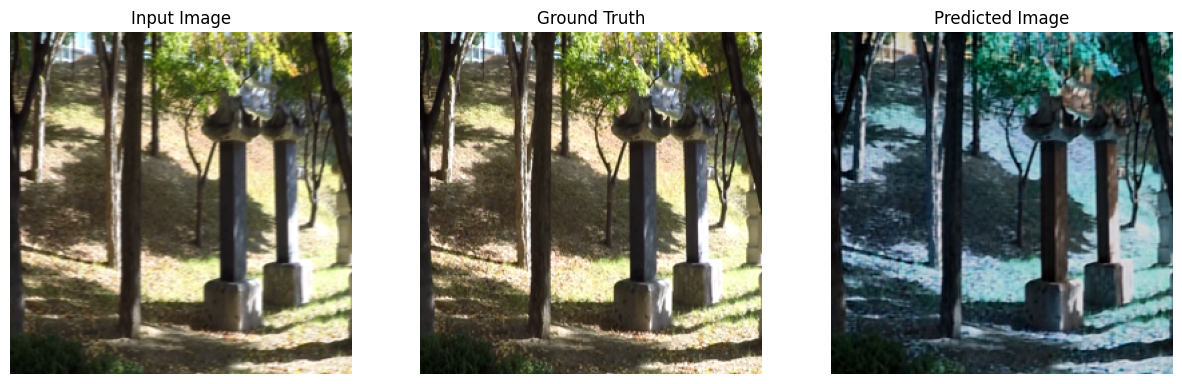

In [ ]:
prediction = interpreter.get_tensor(output_details[0]['index'])

plt.figure(figsize=(15, 15))

display_list = [image_display, tar, prediction[0]]
title = ['Input Image', 'Ground Truth', 'Predicted Image']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
plt.show()

In [ ]:
# Assuming `test_input` is your preprocessed input image
input_details = interpreter_quant.get_input_details()
output_details = interpreter_quant.get_output_details()

interpreter_quant.set_tensor(input_details[0]['index'], image)
interpreter_quant.invoke()

# Get the output tensor
output = interpreter_quant.get_tensor(output_details[0]['index'])

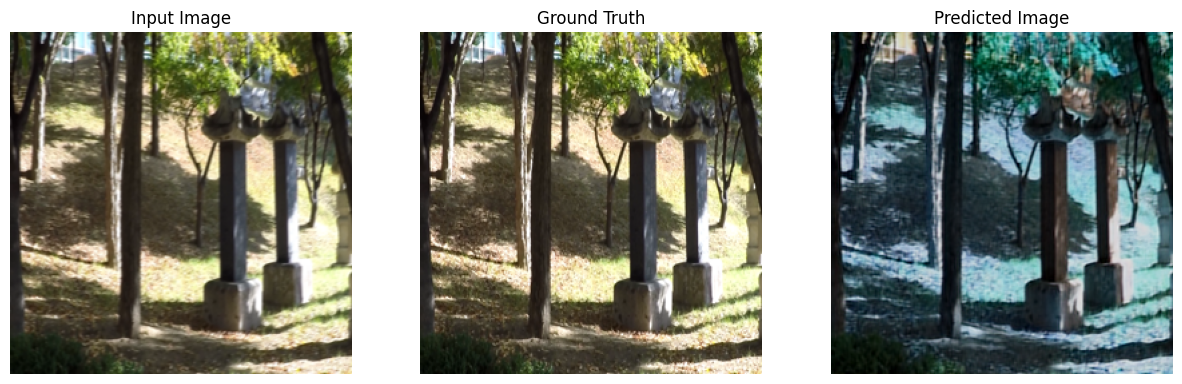

In [ ]:
prediction = interpreter_quant.get_tensor(output_details[0]['index'])

plt.figure(figsize=(15, 15))

display_list = [image_display, tar, prediction[0]]
title = ['Input Image', 'Ground Truth', 'Predicted Image']

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i])
    plt.axis('off')
plt.show()